In [1]:
!pip install ffmpeg-python nb-black

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.5 MB/s eta 0:00:00
  Created wheel for nb-black: filename=nb_black-1.0.7-py3-none-any.whl size=5298 sha256=e671e001000018c93c61d7954c2bda5edf2d1fafbce489c49349ea3284caee48
  Stored in directory: /root/.cache/pip/wheels/79/29/4e/a4405cee966d1019a65c9d6bb6cd1bba039cd9476476703645
Successfully built nb-black


In [2]:
from pathlib import Path
from types import SimpleNamespace

import cv2
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from tqdm import tqdm
import ffmpeg
from IPython.core.display import Video

plt.style.use("default")

cfg = SimpleNamespace()
cfg.INPUT = Path("../input/asl-signs")
cfg.OUTPUT = Path("./animation")
cfg.DEBUG = True

if not cfg.OUTPUT.exists():
    cfg.OUTPUT.mkdir()


%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [3]:
train = pl.read_csv(cfg.INPUT / "train.csv")

In [4]:
pose_edges = [
    {"name": "other", "path": [(9, 10), (11, 12), (23, 24)], "color": (255, 255, 255)},
    {
        "name": "right_eye",
        "path": [(0, 4), (4, 5), (5, 6), (6, 8)],
        "color": (255, 0, 255),
    },
    {
        "name": "left_eye",
        "path": [(0, 1), (1, 2), (2, 3), (3, 7)],
        "color": (0, 0, 255),
    },
    {"name": "right_hand", "path": [(14, 16), (12, 14)], "color": (255, 40, 255)},
    {
        "name": "left_hand",
        "path": [(11, 13), (13, 15)],
        "color": (40, 40, 255),
    },
    {"name": "right_torso", "path": [(12, 24)], "color": (255, 80, 255)},
    {"name": "left_torso", "path": [(11, 23)], "color": (80, 80, 255)},
]
hand_edges = [
    {
        "name": "thumb",
        "path": [(0, 1), (1, 2), (2, 3), (3, 4)],
        "color": (255, 255, 255),
    },
    {"name": "index_finter", "path": [(5, 6), (6, 7), (7, 8)], "color": (120, 40, 150)},
    {
        "name": "middle_finger",
        "path": [(9, 10), (10, 11), (11, 12)],
        "color": (0, 255, 255),
    },
    {
        "name": "ring_finger",
        "path": [(13, 14), (14, 15), (15, 16)],
        "color": (0, 255, 0),
    },
    {
        "name": "little_finger",
        "path": [(17, 18), (18, 19), (19, 20)],
        "color": (255, 0, 0),
    },
    {
        "name": "palm",
        "path": [(0, 5), (5, 9), (9, 13), (13, 17), (17, 0)],
        "color": (140, 140, 140),
    },
    {"name": "", "path": [], "color": ()},
]

In [5]:
def draw_frame(frame, lms_all):
    image = np.zeros((512, 512, 3), np.uint8)

    # process pose
    right_wrist = (None, None)
    left_wrist = (None, None)
    lm = lms_all[frame].filter(
        (pl.col("type") == "pose") & (pl.col("landmark_index") < 25)
    )
    beta = 0.8
    lm = lm.with_columns(
        [
            (pl.col("x") - pl.col("x").first() + 0.5 / beta).alias("x"),
            (pl.col("y") - pl.col("y").first() + 0.15 / beta).alias("y"),
        ]
    )
    right_wrist = (lm["x"][16] * beta, lm["y"][16] * beta)
    left_wrist = (lm["x"][15] * beta, lm["y"][15] * beta)
    upper_lip = (
        (lm["x"][9] + lm["x"][10]) / 2 * beta,
        (lm["y"][9] + lm["y"][9]) / 2 * beta,
    )
    for edge in pose_edges:
        name, paths, color = edge.values()
        for i, j in paths:
            x1, x2, y1, y2 = (
                lm["x"][i] * beta,
                lm["x"][j] * beta,
                lm["y"][i] * beta,
                lm["y"][j] * beta,
            )
            if not ((x1 is None) | (x2 is None) | (y1 is None) | (y2 is None)):
                x1 = int(x1 * 512)
                x2 = int(x2 * 512)
                y1 = int(y1 * 512)
                y2 = int(y2 * 512)
                image = cv2.line(image, (x1, y1), (x2, y2), color, thickness=2)

    # process face
    lm = lms_all[frame].filter(pl.col("type") == "face")
    lm = lm.with_columns(
        [
            (pl.col("x") - pl.col("x").first()).alias("x"),
            (pl.col("y") - pl.col("y").first()).alias("y"),
        ]
    )
    x0, y0 = upper_lip
    if (
        (lm["x"][0] is not None)
        & (lm["y"][0] is not None)
        & (x0 is not None)
        & (y0 is not None)
    ):
        gamma = 0.7
        point_color = (255, 255, 255)
        radius = 1
        for x, y in lm.select(["x", "y"]).to_numpy():
            x, y = x * gamma + x0, y * gamma + y0
            x = int(x * 512)
            y = int(y * 512)
            cv2.circle(image, (x, y), radius, point_color, -1)

    # process hands
    lms = (
        lms_all[frame]
        .filter((pl.col("type") == "right_hand") | (pl.col("type") == "left_hand"))
        .partition_by("type")
    )

    for lm in lms:
        lm = lm.with_columns(
            [
                (pl.col("x") - pl.col("x").first()).alias("x"),
                (pl.col("y") - pl.col("y").first()).alias("y"),
            ]
        )
        lm_type = lm.row(0)[2]
        x0, y0 = right_wrist if (lm_type == "right_hand") else left_wrist
        if (lm["x"][0] is None) | (lm["y"][0] is None) | (x0 is None) | (y0 is None):
            continue
        alpha = 0.6
        for edge in hand_edges:
            name, paths, color = edge.values()
            for i, j in paths:
                x1, x2, y1, y2 = (
                    (lm["x"][i] * alpha + x0),
                    (lm["x"][j] * alpha + x0),
                    (lm["y"][i] * alpha + y0),
                    (lm["y"][j] * alpha + y0),
                )
                if not ((x1 is None) | (x2 is None) | (y1 is None) | (y2 is None)):
                    x1 = int(x1 * 512)
                    x2 = int(x2 * 512)
                    y1 = int(y1 * 512)
                    y2 = int(y2 * 512)
                    image = cv2.line(image, (x1, y1), (x2, y2), color, thickness=2)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Drawing Sample Sequences

landmark data of face and both hands are joined to pose at these key points:

- face: upper lip
- both hands: wrist

Scales are ajusted manually as follows:

- face: 0.7
- both hands: 0.6
- pose: 0.8

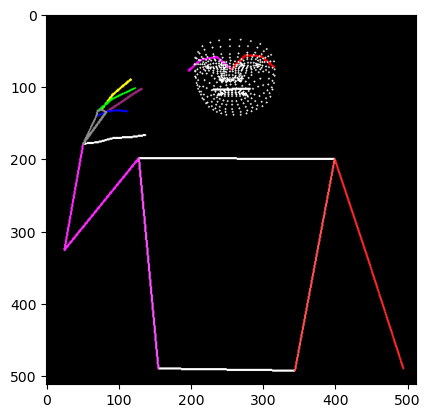

In [6]:
OUTPUT = Path("lm")
if not OUTPUT.exists():
    OUTPUT.mkdir()

lm_data = {
    k: v
    for k, v in zip(
        train.columns,
        train.filter(
            (pl.col("participant_id") == 2044) & (pl.col("sequence_id") == 3356604026)
        ).row(0),
    )
}
df_landmark = pl.read_parquet(cfg.INPUT / lm_data["path"])

df_frames = df_landmark.partition_by("frame")
for idx, frame in enumerate(range(len(df_frames))):
    image = draw_frame(frame, df_frames)

    cv2.imwrite((OUTPUT / f"lm{idx:03d}.png").as_posix(), image)
    plt.imshow(image)

# Making Animation

In [7]:
def make_animation(row, columns, fps: int = 10):
    data = {k: v for k, v in zip(columns, row)}
    sign, participant_id, sequence_id = (
        data["sign"],
        data["participant_id"],
        data["sequence_id"],
    )

    df_landmark = pl.read_parquet(cfg.INPUT / data["path"])
    df_landmark = df_landmark.sort(["frame", "type", "landmark_index"])
    lms_all = df_landmark.partition_by("frame")

    height, width = 512, 512
    if not (cfg.OUTPUT / sign).exists():
        (cfg.OUTPUT / sign).mkdir()

    output_filename = (
        cfg.OUTPUT / sign / f"{participant_id}_{sequence_id}.mp4"
    ).as_posix()
    process = (
        ffmpeg.input("pipe:", format="rawvideo", pix_fmt="rgb24", s=f"{width}x{height}")
        .output(
            output_filename,
            pix_fmt="yuv420p",
            vcodec="libx264",
            r=fps,
            loglevel="quiet",
        )
        .overwrite_output()
        .run_async(pipe_stdin=True)
    )

    for frame in range(len(lms_all)):
        image = draw_frame(frame, lms_all)
        process.stdin.write(image.tobytes())

    process.stdin.close()
    process.wait()

In [8]:
train_unique_signs = train.filter(
    (pl.arange(0, pl.count())).shuffle(seed=42).over("sign") < 5
)

In [9]:
if not cfg.OUTPUT.exists():
    cfg.OUTPUT.mkdir()

if cfg.DEBUG:
    df = train_unique_signs.head(5)
else:
    df = train_unique_signs

for row in tqdm(df.iter_rows(), total=len(df)):
    make_animation(row, df.columns)

  0%|          | 0/5 [00:00<?, ?it/s]ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
 20%|██        | 1/5 [00:00<00:03,  1.16it/s]ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
 40%|████      | 2/5 [00:01<00:01,  1.91it/s]ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
 60%|██████    | 3/5 [00:01<00:00,  2.06it/s]ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /li

In [10]:
!tree animation

animation
├── TV
│   └── 28656_125816896.mp4
├── all
│   └── 26734_1247514751.mp4
├── brother
│   └── 30680_1279123159.mp4
├── bug
│   └── 61333_1268993802.mp4
└── lion
    └── 29302_1271911796.mp4

5 directories, 5 files


In [11]:
Video("animation/TV/28656_125816896.mp4")

In [12]:
Video("animation/all/26734_1247514751.mp4")

In [13]:
Video("animation/bug/61333_1268993802.mp4")

In [14]:
Video("animation/lion/29302_1271911796.mp4")